In [9]:
from platform import python_version
python_version()

'3.6.12'

In [10]:
import numpy as np
#import tensorflow as tf
#import keras as k
import pandas as pd
import matplotlib.pyplot as plt
#import cv2 
import math
import os
import time
from sklearn.metrics import roc_auc_score

In [11]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

## functions 

In [12]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

In [13]:
#List of metric for classiffication models 

def metrics_classific(y,predicted,prob_predict,X):
    from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score,log_loss
    confusion_matrix = confusion_matrix(y, predicted)
    print(confusion_matrix)
    print(classification_report(y, predicted))

    # Validation ROC-AUC score
    from sklearn.metrics import roc_auc_score
    valid_score = roc_auc_score(y, predicted)
    print('Validation ROC-AUC score:', valid_score)

    # AUC score
    from sklearn.metrics import  auc
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, predicted)
    auc = auc(false_positive_rate, true_positive_rate)
    print('Validation AUC score:    ', auc)
    print("Accuracy: %.2f%%" % (accuracy_score(y, predicted) * 100.0))
    print("LogLoss :", log_loss(y_test,prob_predict))

In [14]:
def sigmoid(z):
    return 1/(1.0 + np.exp(-z))

In [15]:
#transform prob_prediction to predictions 
def predictor(prob_prediction):
    return np.array(([propability[0] < propability[1] for propability in prob_prediction]), dtype=int)

# Import dataset

In [16]:
X_true = pd.read_csv('X_true.csv').values
y_true = pd.read_csv('y_true.csv').values

In [17]:
X_true.shape, y_true.shape

((10800, 12288), (10800, 1))

## Split data

In [18]:
from sklearn.model_selection import train_test_split
seed = 78
test_size = 0.33
X_train, X_, y_train, y_ = train_test_split(X_true, y_true, test_size=test_size, random_state=seed)
X_test, X_validate, y_test, y_validate = train_test_split(X_, y_, test_size=test_size, random_state=seed)

In [19]:
print('X_train size :', X_train.shape[0],'X_validate size :', X_validate.shape[0], 'X_test size :',X_test.shape[0])

X_train size : 7236 X_validate size : 1177 X_test size : 2387


In [20]:
%%time 
# Benchmark
from sklearn.linear_model import Perceptron
Per = Perceptron(random_state=seed).fit(X_train, y_train)
predictions = Per.predict(X_test)
prob_predict = Per.decision_function(X_test)
metrics_classific(y_test,predictions,prob_predict, X_test)

[[939 129]
 [503 816]]
              precision    recall  f1-score   support

         0.0       0.65      0.88      0.75      1068
         1.0       0.86      0.62      0.72      1319

    accuracy                           0.74      2387
   macro avg       0.76      0.75      0.73      2387
weighted avg       0.77      0.74      0.73      2387

Validation ROC-AUC score: 0.7489319879718206
Validation AUC score:     0.7489319879718206
Accuracy: 73.52%
LogLoss : 9.144788366004208
Wall time: 9.96 s


In [21]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(random_state=seed).fit(X_train, y_train)
predictions = lg.predict(X_test)
prob_predict = lg.predict_proba(X_test)
metrics_classific(y_test,predictions,prob_predict, X_test)

[[ 830  238]
 [ 226 1093]]
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78      1068
         1.0       0.82      0.83      0.82      1319

    accuracy                           0.81      2387
   macro avg       0.80      0.80      0.80      2387
weighted avg       0.81      0.81      0.81      2387

Validation ROC-AUC score: 0.8029058161755729
Validation AUC score:     0.8029058161755729
Accuracy: 80.56%
LogLoss : 0.8507220750626487


# Perceptron

In [22]:
shape = y_train.shape
y_orig = y_train.reshape(shape[0],1)

from sklearn.preprocessing import OneHotEncoder
oneHot = OneHotEncoder()
oneHot.fit(y_orig) 
data_y = oneHot.transform(y_orig).toarray()

In [23]:
shape = y_test.shape
y_test_orig = y_test.reshape(shape[0],1)

from sklearn.preprocessing import OneHotEncoder
oneHot = OneHotEncoder()
oneHot.fit(y_test_orig) 
test_y = oneHot.transform(y_test_orig).toarray() 

In [24]:
data_x = X_train 
data_x.shape, data_y.shape

((7236, 12288), (7236, 2))

## model parameters

In [25]:
#Input pretrained parameters
W = pd.read_csv('weights.csv',header=None).values
b = pd.read_csv('bias.csv',header=None).values

W = tf.Variable(tf.convert_to_tensor(W, dtype=tf.float32))
b = tf.Variable(tf.convert_to_tensor(b, dtype=tf.float32))

In [29]:
learning_rate = 0.02
L2 =0.0001 #regulization
n_epochs = 9000

num_features = data_x.shape[1]
num_classes = data_y.shape[1]

X_hold = tf.placeholder(tf.float32, [None, num_features]) 
Y_hold = tf.placeholder(tf.float32, [None,num_classes])

##random weights
#W = tf.Variable(tf.truncated_normal([num_features, num_classes], stddev=0.1))

##specific weights
#Initial_W = pd.read_csv('Initial_W.csv',header=None).values
#W = tf.Variable(tf.convert_to_tensor(Initial_W, dtype=tf.float32))

b = tf.Variable(tf.constant(0.1, shape=[num_classes]))

Z = tf.matmul(X_hold,W) + b
logit = tf.sigmoid(Z)

## Cost function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y_hold, logits=logit)+ L2*tf.nn.l2_loss(W))
#loss = tf.reduce_mean(-tf.reduce_sum(Y_hold * tf.log(logit), reduction_indices=[0]))
#logloss = Y_hold * -tf.log(logit) + (1 - Y_hold) * tf.log(1 - logit)

#Optimizator
optimizator = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss) #Gradient Descent
#optimizator = tf.train.AdamOptimizer(learning_rate).minimize(loss) # Adam  

train_acc = []
test_acc = []
losses = []
aucs = []
# Define the accuracy
prediction = tf.round(logit)
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, Y_hold), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)

## Initial session

In [30]:
%%time
##Initial session
saver = tf.train.Saver()

with tf.Session() as sess:
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    #save initial weights
    Initial_W = sess.run(W)
    
    # Gradient descent
    for i in range(0,n_epochs):
        _, iloss, y_hat, temp_train_acc =  sess.run([optimizator, loss, prediction, accuracy], {X_hold:data_x, Y_hold:data_y})
        temp_test_acc = sess.run(accuracy, feed_dict={X_hold:X_test, Y_hold:test_y})
        if i%100==0:
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            losses.append(iloss)
            aucs.append(roc_auc_score(data_y, y_hat))
        if i%100==0:
            print('%i th Epoch Train AUC: %.4f Loss: %.4f' % (i, roc_auc_score(data_y, y_hat), iloss))
     
    # Calculate test auc
    prob_predictions = sess.run(Z, feed_dict={X_hold:X_test})
    weights = sess.run(W)
    bias = sess.run(b)
    saver.save(sess, 'example_long')

0 th Epoch Train AUC: 0.6628 Loss: 0.6397
100 th Epoch Train AUC: 0.6376 Loss: 0.6490
200 th Epoch Train AUC: 0.6682 Loss: 0.6377
300 th Epoch Train AUC: 0.6641 Loss: 0.6391
400 th Epoch Train AUC: 0.6689 Loss: 0.6374
500 th Epoch Train AUC: 0.6702 Loss: 0.6370
600 th Epoch Train AUC: 0.6703 Loss: 0.6370
700 th Epoch Train AUC: 0.6632 Loss: 0.6394
800 th Epoch Train AUC: 0.6558 Loss: 0.6421
900 th Epoch Train AUC: 0.6601 Loss: 0.6405
1000 th Epoch Train AUC: 0.6705 Loss: 0.6369
1100 th Epoch Train AUC: 0.6454 Loss: 0.6459
1200 th Epoch Train AUC: 0.6713 Loss: 0.6364
1300 th Epoch Train AUC: 0.6711 Loss: 0.6366
1400 th Epoch Train AUC: 0.6714 Loss: 0.6363
1500 th Epoch Train AUC: 0.6249 Loss: 0.6537
1600 th Epoch Train AUC: 0.6556 Loss: 0.6422
1700 th Epoch Train AUC: 0.6329 Loss: 0.6506
1800 th Epoch Train AUC: 0.6717 Loss: 0.6361
1900 th Epoch Train AUC: 0.6596 Loss: 0.6407
2000 th Epoch Train AUC: 0.6721 Loss: 0.6361
2100 th Epoch Train AUC: 0.6722 Loss: 0.6360
2200 th Epoch Train AU

KeyboardInterrupt: 

In [31]:
tensor_predictions = predictor(prob_predictions)
metrics_classific(y_test,tensor_predictions,prob_predictions, X_test)

[[ 158  910]
 [  46 1273]]
              precision    recall  f1-score   support

         0.0       0.77      0.15      0.25      1068
         1.0       0.58      0.97      0.73      1319

    accuracy                           0.60      2387
   macro avg       0.68      0.56      0.49      2387
weighted avg       0.67      0.60      0.51      2387

Validation ROC-AUC score: 0.5565325848375656
Validation AUC score:     0.5565325848375656
Accuracy: 59.95%
LogLoss : 2.766396620262853


ValueError: x and y must have same first dimension, but have shapes (90,) and (42,)

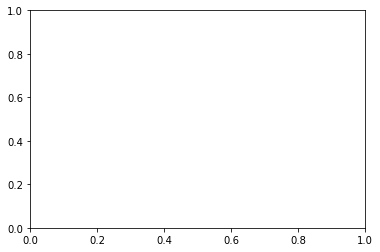

In [32]:
plt.plot(range(n_epochs//100), losses)
plt.title('Loss')
plt.xlabel('Iteration')
_ = plt.ylabel('RMSE') 

In [ ]:
 plt.plot(range(800//100), aucs)
plt.title('AUC')
plt.xlabel('Iteration')
_ = plt.ylabel('AUC Score') 

train accuracy : 0.66450274
test accuracy : 0.6276685


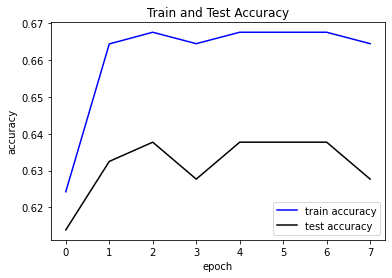

In [74]:
##learning_rate = 0.1
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
print("train accuracy :",train_acc[-1] )
print("test accuracy :",test_acc[-1] )
plt.show()

In [75]:
max(test_acc)

0.6377145

## restored session 1

In [76]:
%%time
##restored session
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('example_long.meta')
    sess.run(tf.global_variables_initializer())
    new_saver.restore(sess,tf.train.latest_checkpoint('./'))
     
    # Gradient descent
    for i in range(0,200):
        _, iloss, y_hat, temp_train_acc =  sess.run([optimizator, loss, prediction, accuracy], {X_hold:data_x, Y_hold:data_y})
        temp_test_acc = sess.run(accuracy, feed_dict={X_hold:X_test, Y_hold:test_y})
        if i%100==0:
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            losses.append(iloss)
            aucs.append(roc_auc_score(data_y, y_hat))
        if i%100==0:
            print('%i th Epoch Train AUC: %.4f Loss: %.4f' % (i, roc_auc_score(data_y, y_hat), iloss))
    
    
    # Calculate test auc
    prob_predictions = sess.run(Z, feed_dict={X_hold:X_test})
    
    weights = sess.run(W)
    bias = sess.run(b)
    #new_saver.save(sess, 'example2')   

INFO:tensorflow:Restoring parameters from ./example_long
0 th Epoch Train AUC: 0.6545 Loss: 0.6430
100 th Epoch Train AUC: 0.6519 Loss: 0.6435
Wall time: 2min


In [77]:
tensor_predictions = predictor(prob_predictions)
metrics_classific(y_test,tensor_predictions,prob_predictions, X_test)

[[ 186  888]
 [  60 1255]]
              precision    recall  f1-score   support

         0.0       0.76      0.17      0.28      1074
         1.0       0.59      0.95      0.73      1315

    accuracy                           0.60      2389
   macro avg       0.67      0.56      0.50      2389
weighted avg       0.66      0.60      0.53      2389

Validation ROC-AUC score: 0.563778490558022
Validation AUC score:     0.563778490558022
Accuracy: 60.32%
LogLoss : 2.6410546228196043


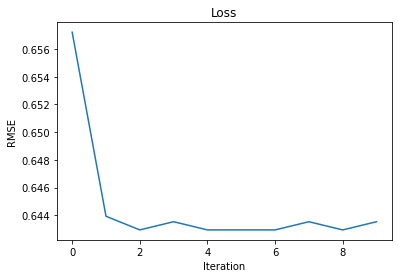

In [78]:
 plt.plot(range(len(losses)), losses)
plt.title('Loss')
plt.xlabel('Iteration')
_ = plt.ylabel('RMSE') 

train accuracy : 0.66450274
test accuracy : 0.6276685


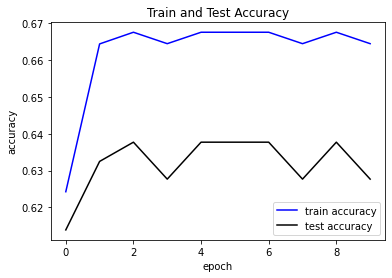

In [79]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
print("train accuracy :",train_acc[-1] )
print("test accuracy :",test_acc[-1] )
plt.show()

## Save model

In [80]:
#Save model
from numpy import loadtxt
np.savetxt('Initial_W.csv', Initial_W, delimiter=',')
np.savetxt('weights.csv', weights, delimiter=',')
np.savetxt('bias.csv', bias, delimiter=',')

# Model validation

In [81]:
#Load model
weights = pd.read_csv('weights.csv',header=None).values
bias = pd.read_csv('bias.csv',header=None).values

In [82]:
#check test matrics
test_predict = np.dot(np.array(X_test),weights)
new_test_predict = np.zeros(shape=(test_predict.shape))
for i in range(len(test_predict)):
    new_test_predict[i] = [test_predict[i][0]+bias[0], test_predict[i][1]+bias[1]]
valudate_predictions = predictor(new_test_predict)

In [83]:
metrics_classific(y_test,valudate_predictions,sigmoid(new_test_predict), X_test)  

[[ 186  888]
 [  60 1255]]
              precision    recall  f1-score   support

         0.0       0.76      0.17      0.28      1074
         1.0       0.59      0.95      0.73      1315

    accuracy                           0.60      2389
   macro avg       0.67      0.56      0.50      2389
weighted avg       0.66      0.60      0.53      2389

Validation ROC-AUC score: 0.563778490558022
Validation AUC score:     0.563778490558022
Accuracy: 60.32%
LogLoss : 2.70339226761092


In [84]:
sigmoid(new_test_predict).shape

(2389, 2)

In [85]:
X_validate.shape

(1177, 12288)

In [86]:
#Model validation
val_predict = np.dot(np.array(X_validate),weights)
new_val_predict = np.zeros(shape=(val_predict.shape))
for i in range(len(val_predict)):
    new_val_predict[i] = [val_predict[i][0]+bias[0], val_predict[i][1]+bias[1]]

valudate_predictions = predictor(new_val_predict)
metrics_classific(y_validate,valudate_predictions, sigmoid(new_test_predict), X_validate)

[[ 99 446]
 [ 25 607]]
              precision    recall  f1-score   support

         0.0       0.80      0.18      0.30       545
         1.0       0.58      0.96      0.72       632

    accuracy                           0.60      1177
   macro avg       0.69      0.57      0.51      1177
weighted avg       0.68      0.60      0.52      1177

Validation ROC-AUC score: 0.5710472070607363
Validation AUC score:     0.5710472070607363
Accuracy: 59.98%
LogLoss : 2.70339226761092
